# Global Climate Change
### A Data Science Tutorial by Jamie Lebovics
According to NASA$_1$, at least 97% of scientists believe that global climate change is real, and that it is caused by human activity. Yet, it is still considered a controversial debate topic, and many people are misinformed, and people in power are not adequately changing policies to alleviate the problem that our planet is facing, and by extension, the entire population is facing.

This tutorial will show how to look at some existing data about the global and United States climate and visualize it in a way that meaningfully conveys that climate change is real. It is important to continue to do analyses like this one in order to continue to educate those who may be misinformed because of the other 3% of scientists who have gotten a disproportionate voice, making people doubt the need for policy changes aimed at stopping climate change.

Further, I'll explore at how different parts of the world may be affected differently.

1 - source and further reading: https://climate.nasa.gov/scientific-consensus/

### Data Collection
I downloaded climate data from Kaggle$_2$, which is behind a login and therefore could not be included directly in this tutorial, and wrote the data to a pandas DataFrame. Then, since I also need information about where each country is bycontinent and region, I accessed the a raw table with this information that has been hosted publicly on github$_3$

2 - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

3 - https://githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv

In [19]:
import requests

url = "https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv"
r = requests.get(url)
r.text

'name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,region-code,sub-region-code\nAfghanistan,AF,AFG,004,ISO 3166-2:AF,Asia,Southern Asia,142,034\nÅland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,150,154\nAlbania,AL,ALB,008,ISO 3166-2:AL,Europe,Southern Europe,150,039\nAlgeria,DZ,DZA,012,ISO 3166-2:DZ,Africa,Northern Africa,002,015\nAmerican Samoa,AS,ASM,016,ISO 3166-2:AS,Oceania,Polynesia,009,061\nAndorra,AD,AND,020,ISO 3166-2:AD,Europe,Southern Europe,150,039\nAngola,AO,AGO,024,ISO 3166-2:AO,Africa,Middle Africa,002,017\nAnguilla,AI,AIA,660,ISO 3166-2:AI,Americas,Caribbean,019,029\nAntarctica,AQ,ATA,010,ISO 3166-2:AQ,,,,\nAntigua and Barbuda,AG,ATG,028,ISO 3166-2:AG,Americas,Caribbean,019,029\nArgentina,AR,ARG,032,ISO 3166-2:AR,Americas,South America,019,005\nArmenia,AM,ARM,051,ISO 3166-2:AM,Asia,Western Asia,142,145\nAruba,AW,ABW,533,ISO 3166-2:AW,Americas,Caribbean,019,029\nAustralia,AU,AUS,036,ISO 3166-2:AU,Oceania,Australia and New Zealand,009,053\nAustria

### Data Processing
First, I'll import packages for managing and visualizing data

In [2]:
import pandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import datetime

The table with region info on each country has to be converted from a csv to a pandas DataFrame. There are commas in some of the country names which have to be specially accounted for since the columns are also separated by columns.

In [20]:
# this should have been a one-line list comprehension but some countries have a comma in their names and quotes
# instead of an escape character so i needed to account for the special case
regions = []
for row in r.text.split('\n'):
    if '\"' not in row:
        regions.append([col for col in row.split(',')])
    else:
        lst = [col for col in row.split(',')]
        name = (lst[0]+", "+lst[1]).strip('\"')
        lst = lst[2:]
        lst.insert(0,name)
        regions.append(lst)
    
regions = pandas.DataFrame(regions[1:], columns=regions[0])
regions.set_index('name', inplace=True)
regions.head()

,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,region-code,sub-region-code
name,,,,,,,,
Afghanistan,AF,AFG,004,ISO 3166-2:AF,Asia,Southern Asia,142,034
Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,150,154
Albania,AL,ALB,008,ISO 3166-2:AL,Europe,Southern Europe,150,039
Algeria,DZ,DZA,012,ISO 3166-2:DZ,Africa,Northern Africa,002,015
American Samoa,AS,ASM,016,ISO 3166-2:AS,Oceania,Polynesia,009,061


Next, process the climate data by creating a pandas DataFrame, and adding columns with DateTime and year information, derived from the string date column 'dt'

In [4]:
data = pandas.DataFrame.from_csv('GlobalLandTemperaturesByCountry.csv', index_col=None)

#dt = [datetime.datetime.strptime(dt,'%Y-%m-%d') for dt in data['dt']]
#data['DateTime'] = dt

year = [int(dt[:4]) for dt in data['dt']]
data['year'] = year

# Impute rows without temperatures listed
data = data[data['AverageTemperature'].isnull()==False]

data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,DateTime,year
0,1743-11-01,4.384,2.294,Åland,1743-11-01,1743
5,1744-04-01,1.530,4.680,Åland,1744-04-01,1744
6,1744-05-01,6.702,1.789,Åland,1744-05-01,1744
7,1744-06-01,11.609,1.577,Åland,1744-06-01,1744
8,1744-07-01,15.342,1.410,Åland,1744-07-01,1744


Calculate the yearly averages for each country and add them to the DataFrame

In [5]:
intermediate = data.groupby(['Country', 'year']).mean().reset_index()
intermediate.rename(columns={'AverageTemperature': 'YearlyAverageTemperature', \
                             'AverageTemperatureUncertainty': 'YearlyAverageTemperatureUncertainty'}, inplace=True)

data = pandas.merge(data, intermediate, how='right', on=['Country', 'year'])
data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,DateTime,year,YearlyAverageTemperature,YearlyAverageTemperatureUncertainty
0,1743-11-01,4.384,2.294,Åland,1743-11-01,1743,4.3840,2.294000
1,1744-04-01,1.530,4.680,Åland,1744-04-01,1744,6.6985,1.987625
2,1744-05-01,6.702,1.789,Åland,1744-05-01,1744,6.6985,1.987625
3,1744-06-01,11.609,1.577,Åland,1744-06-01,1744,6.6985,1.987625
4,1744-07-01,15.342,1.410,Åland,1744-07-01,1744,6.6985,1.987625


Add the region data (only the region and sub-region columns) into the main DataFrame.

In [48]:
q = []
for country in data['Country'].unique():
    for c in regions.itertuples():
        if country in c.Index:
            q.append([country, c.region, c._6])

df = pandas.DataFrame(q, columns=['Country','region','sub_region'])
data = pandas.merge(data, df, how='right', on=['Country'])
data

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,DateTime,year,YearlyAverageTemperature,YearlyAverageTemperatureUncertainty,region,sub_region
0,1743-11-01,4.384,2.294,Åland,1743-11-01,1743,4.384000,2.294000,Europe,Northern Europe
1,1744-04-01,1.530,4.680,Åland,1744-04-01,1744,6.698500,1.987625,Europe,Northern Europe
2,1744-05-01,6.702,1.789,Åland,1744-05-01,1744,6.698500,1.987625,Europe,Northern Europe
3,1744-06-01,11.609,1.577,Åland,1744-06-01,1744,6.698500,1.987625,Europe,Northern Europe
4,1744-07-01,15.342,1.410,Åland,1744-07-01,1744,6.698500,1.987625,Europe,Northern Europe
5,1744-09-01,11.702,1.517,Åland,1744-09-01,1744,6.698500,1.987625,Europe,Northern Europe
6,1744-10-01,5.477,1.862,Åland,1744-10-01,1744,6.698500,1.987625,Europe,Northern Europe
7,1744-11-01,3.407,1.425,Åland,1744-11-01,1744,6.698500,1.987625,Europe,Northern Europe
8,1744-12-01,-2.181,1.641,Åland,1744-12-01,1744,6.698500,1.987625,Europe,Northern Europe
9,1745-01-01,-3.850,1.841,Åland,1745-01-01,1745,-3.896500,1.396500,Europe,Northern Europe


### Exploratory Analysis & Data Visualization
Next, I'll plot some of the data what has been collected, processed, and compiled into a single DataFrame. There will be plots for the United States, the world divided by region, and each continent divided by sub-region.

In [ ]:
from ggplot import *
import numpy as np
from sklearn import linear_model
from patsy import dmatrices
from statsmodels import regression
import warnings
warnings.filterwarnings('ignore')

Below, the plot for the the United States clearly shows a gradual rise in temperature.

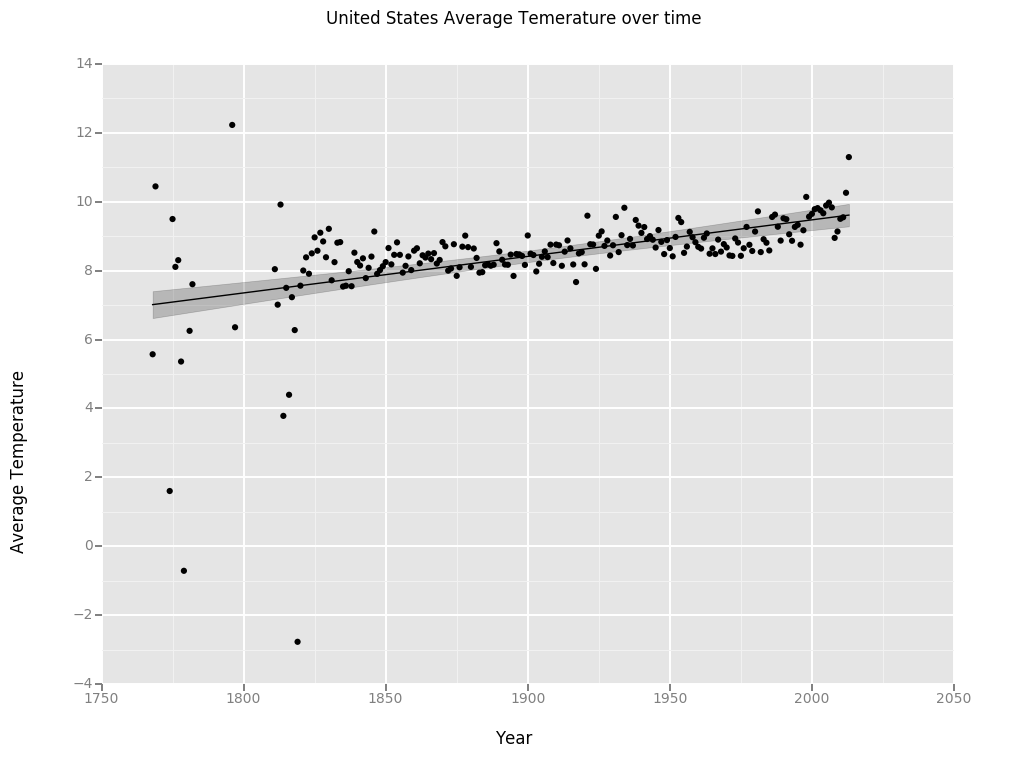

<ggplot: (-9223372036562409924)>

In [86]:
us_data = data[['Country','year','YearlyAverageTemperature','YearlyAverageTemperatureUncertainty']].drop_duplicates()\
[data['Country']=="United States"]

ggplot(aes(x='year', y='YearlyAverageTemperature'), data=us_data) +\
    geom_point() +\
    ggtitle("United States Average Temerature over time") +\
    xlab('Year') +\
    ylab('Average Temperature') +\
    stat_smooth(span=0.2)

Next, we'll look at global data, and see if the world regions are useful ways of grouping climates.

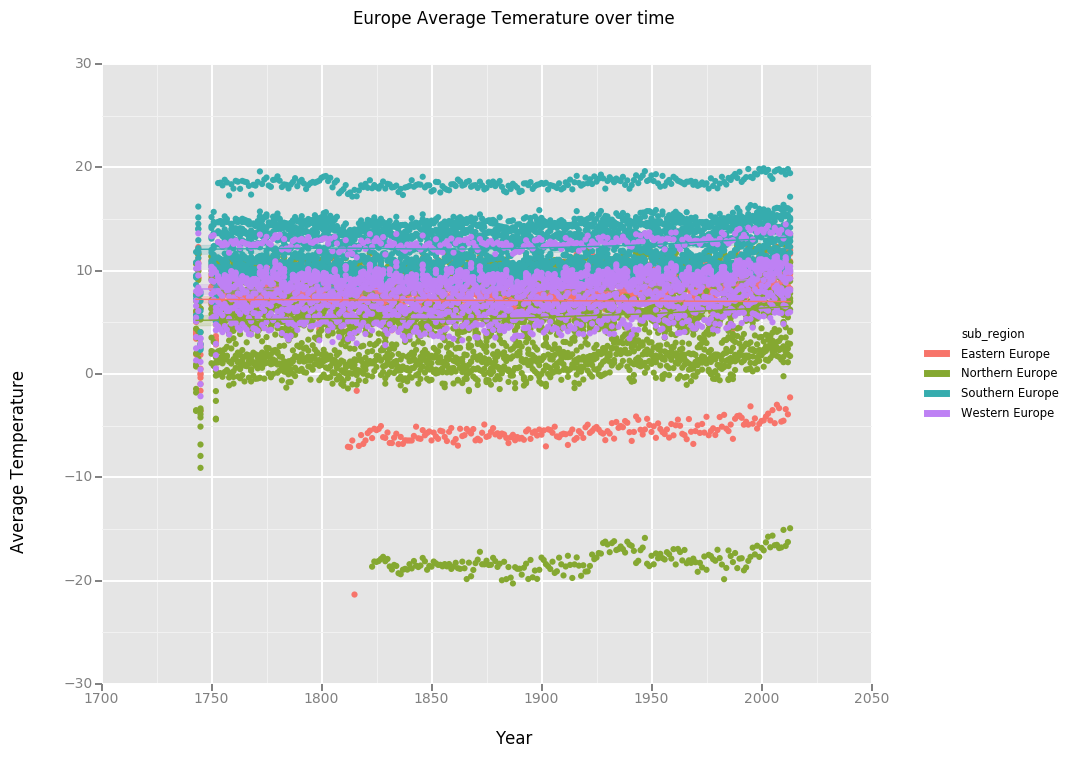

<ggplot: (-9223372036560479863)>


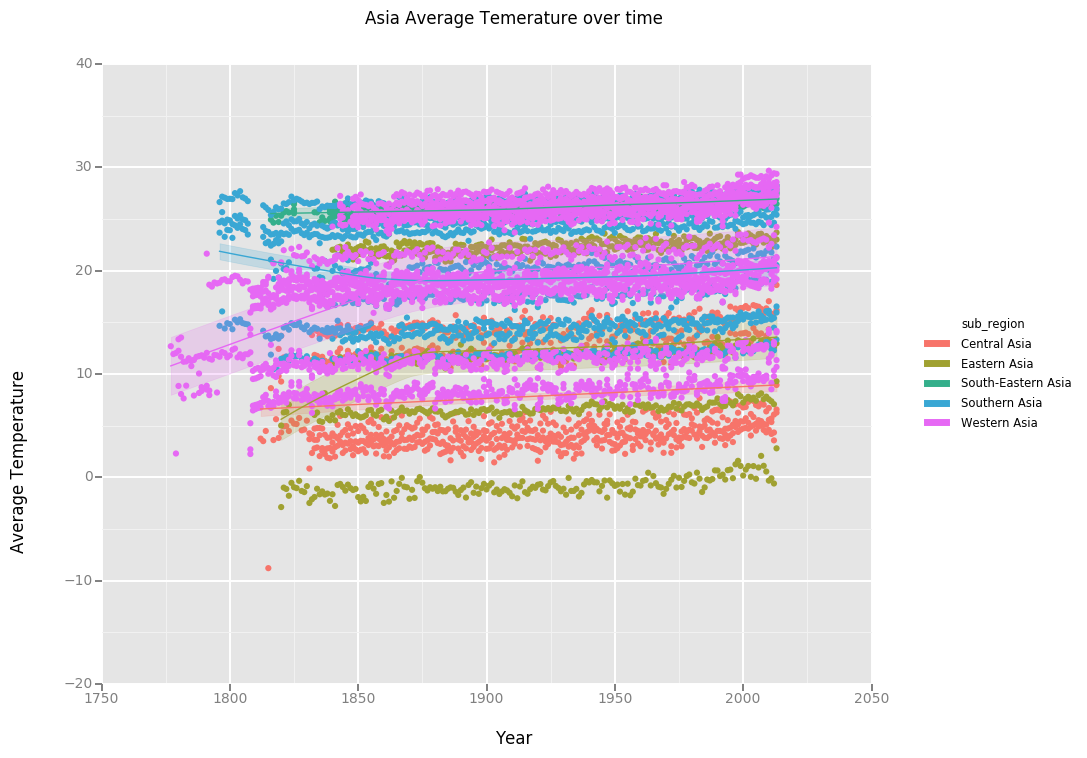

<ggplot: (295520709)>


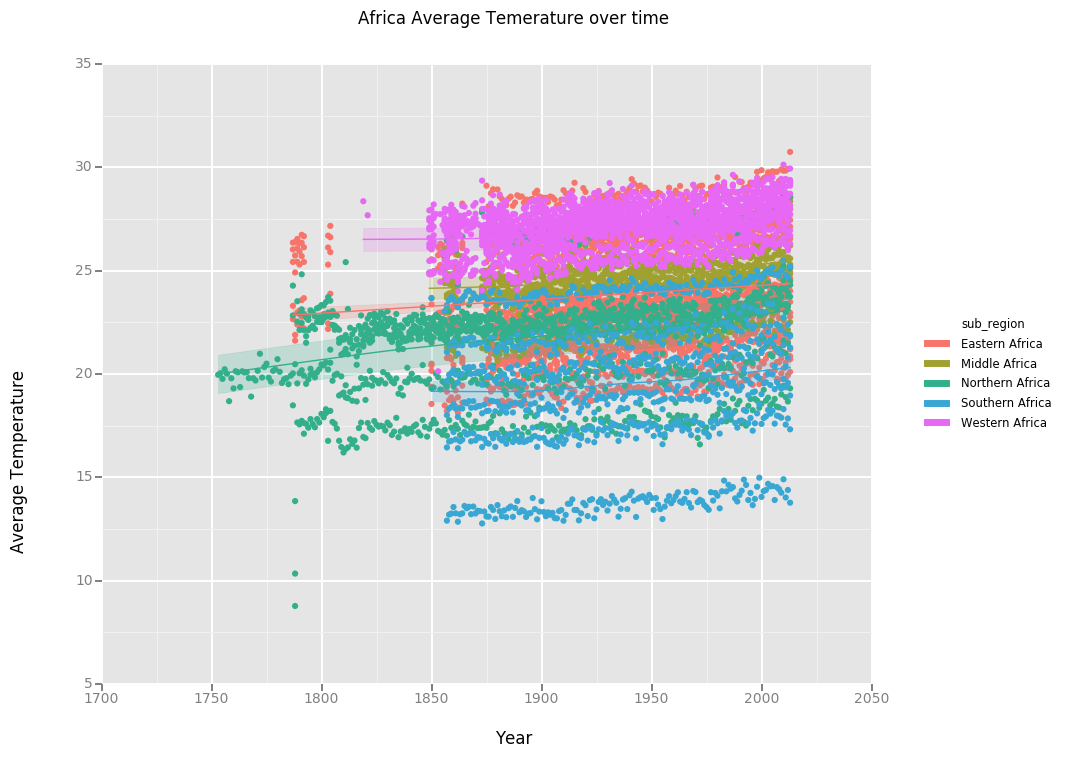

<ggplot: (294746909)>


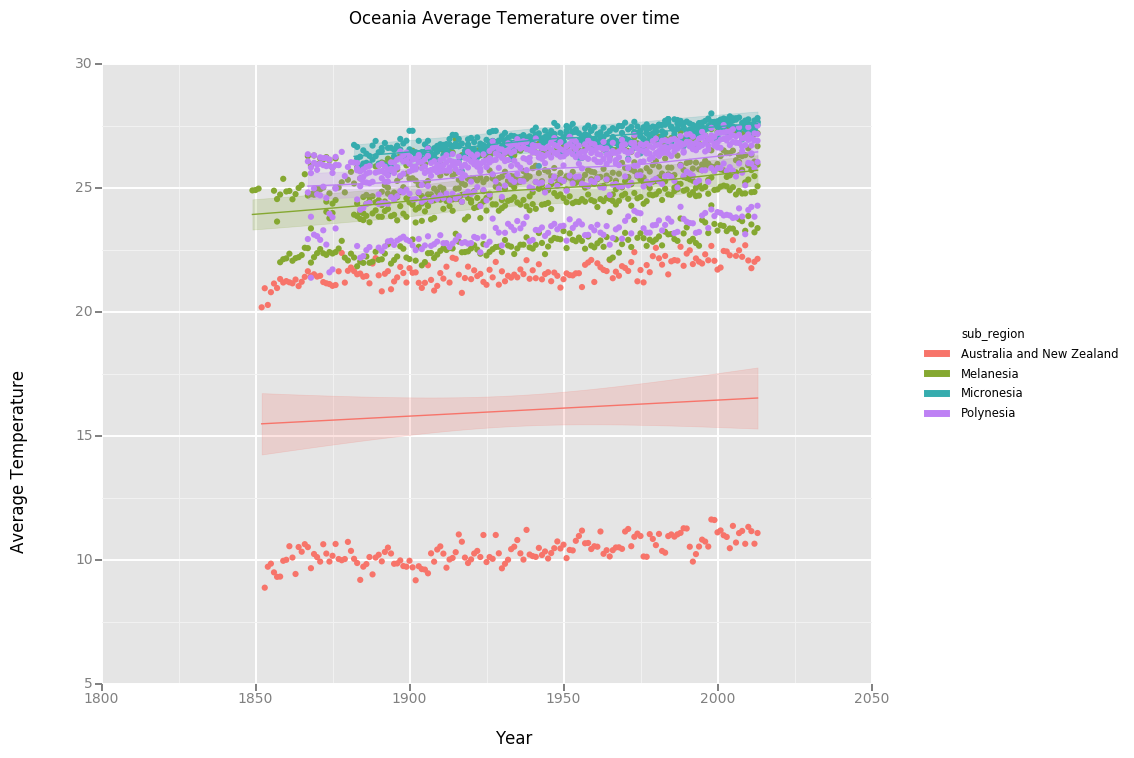

<ggplot: (-9223372036560036429)>


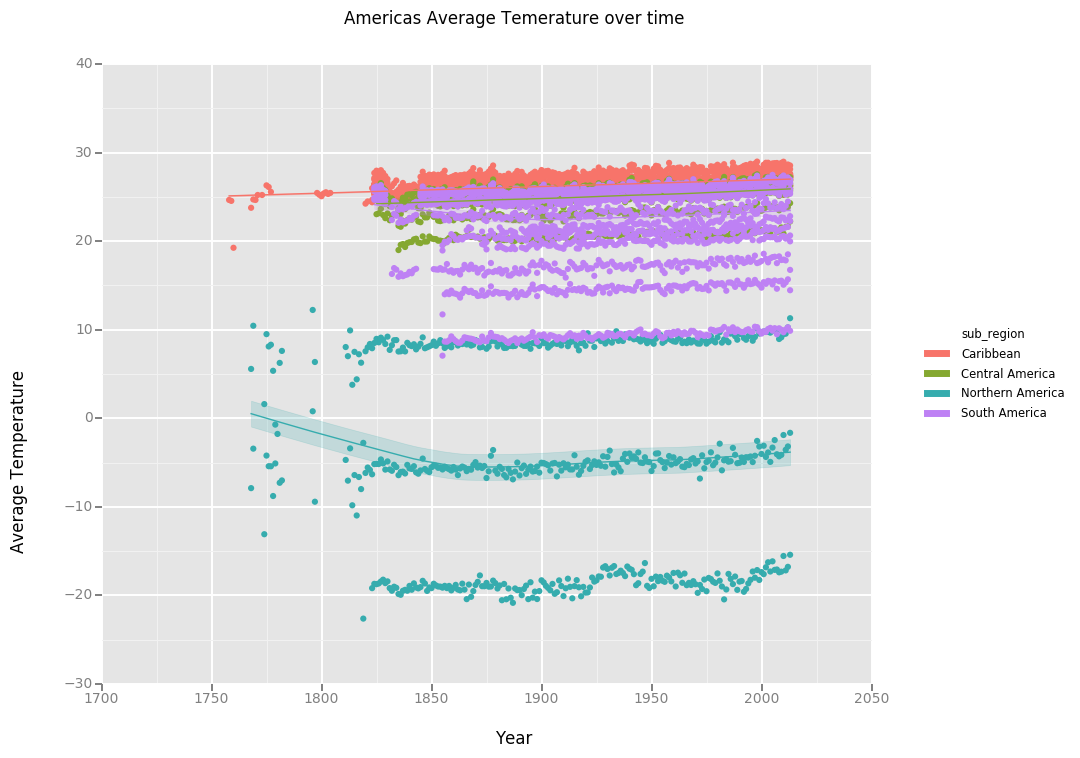

<ggplot: (-9223372036559343381)>


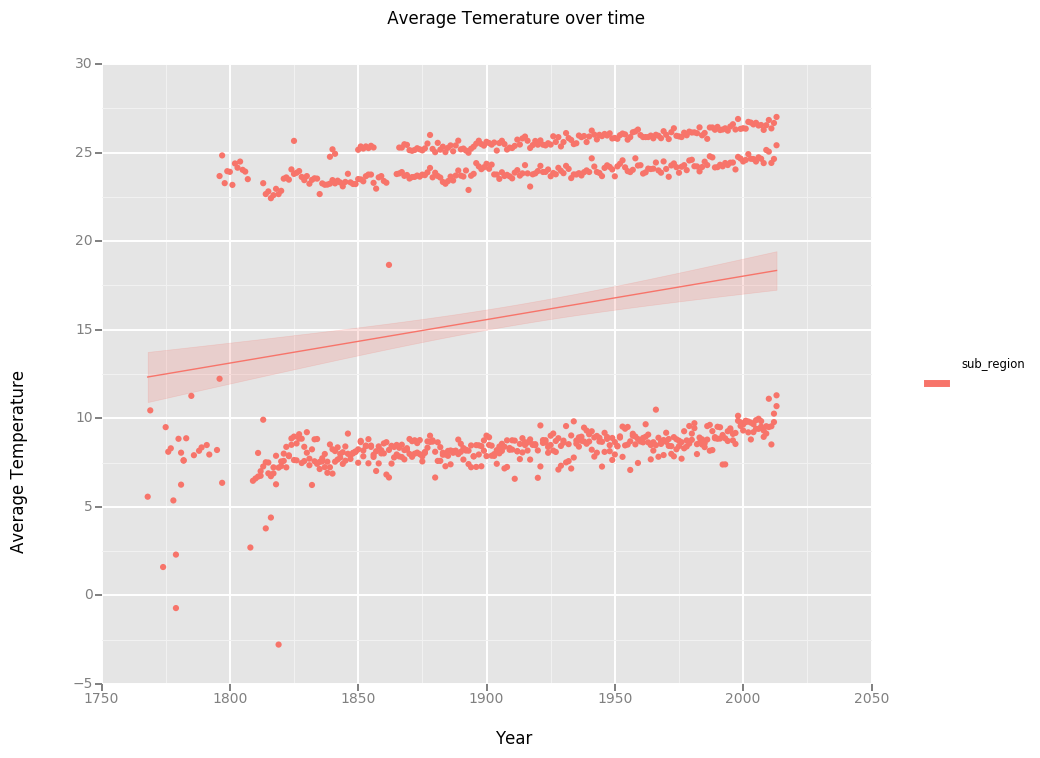

<ggplot: (294802615)>


In [87]:
global_data = data[['Country','year','YearlyAverageTemperature','YearlyAverageTemperatureUncertainty',\
                    'region','sub_region']].drop_duplicates()

for r in data['region'].unique():
    g = ggplot(aes(x='year', y='YearlyAverageTemperature', color='sub_region'), \
               data=global_data[global_data['region']==r]) +\
        geom_point() +\
        ggtitle("%s Average Temerature over time"%(r)) +\
        xlab('Year') +\
        ylab('Average Temperature') +\
        stat_smooth(colour='blue', span=0.5)
    print(g)

It turns out the temperatures don't cluster well by region. Since climate and global temparature patterns are quite complex, it would be interesting to explore further and see what would be a good way to group temperature by locations, and I'll be doing exactly that in the next section.
### Machine Learning
The goal in this section is to find a new set of regions that better predicts the tempaerature trends of those countries within that region. Some large countries, like the United States, Russia, and Australia would probably benefit from being divided further into smaller regions to anylize, but for the simplicity I'll consider a country to be the smallest geographic unit.